In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pandas import DataFrame
from datetime import datetime, date

from sklearn import preprocessing

In [2]:
# Set rnadom seed
tf.set_random_seed(77777)

In [3]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [4]:
# Hyper parameter
seq_length = 7
data_dim = 6 # Feature 개수
hidden_dim = 10
output_dim = 1
predict_day = 1 # 바로 다음 날
learning_rate = 0.005
iterations = 5000
LSTM_stack = 3

In [5]:
pred_label = 3 # Timestamp,Open,High,Low,Close,Volume,Currency,Weighted Price => Close => 종가 예측

In [6]:
df = pd.read_csv('bitcoin_rate.csv',delimiter=',', engine='python')
df = df[:2220]
df = df.set_index('Date')
del df['Currency']
del df['Unnamed: 0']
del df['Open']
del df['High']
del df['Low']
del df['Close']
del df['Weighted_Price']
del df['Volume']

In [7]:
df.tail()

,Open_rate,High_rate,Low_rate,Close_rate,Volume_rate,Weighted_Price_rate
Date,,,,,,
2017-10-27,2.59,0.10,-0.16,-2.01,1.04,-1.07
2017-10-28,-1.99,-1.98,-0.49,-0.71,-50.25,-1.06
2017-10-29,-0.72,7.51,0.65,7.10,171.44,4.43
2017-10-30,7.00,-1.38,6.00,-0.28,-40.48,2.24
2017-10-31,-0.21,3.53,0.81,5.13,40.20,2.61


In [8]:
length = df.shape[0] # data lenght
length

2220

In [9]:
# now = datetime.now()
# year = now.year
# month = now.month
# day = now.day

# print(year)
# print(month)
# print(day)

# for i in range(1,predict_day+1):
#     df.loc[length+i] = df.iloc[length-1]
#     df.index.values[length+i-1]= datetime(year, month, day+i-1)

In [10]:
df.tail()

,Open_rate,High_rate,Low_rate,Close_rate,Volume_rate,Weighted_Price_rate
Date,,,,,,
2017-10-27,2.59,0.10,-0.16,-2.01,1.04,-1.07
2017-10-28,-1.99,-1.98,-0.49,-0.71,-50.25,-1.06
2017-10-29,-0.72,7.51,0.65,7.10,171.44,4.43
2017-10-30,7.00,-1.38,6.00,-0.28,-40.48,2.24
2017-10-31,-0.21,3.53,0.81,5.13,40.20,2.61


### Convert pandas df to nparray

In [11]:
dataset = df.as_matrix()
dataset

array([[   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ],
       [  -3.79,   -4.67,   -2.3 ,   -7.37,    4.75,   -5.71],
       [  -8.24,   -8.39,   -9.42,   -7.23,   31.06,   -8.88],
       ..., 
       [  -0.72,    7.51,    0.65,    7.1 ,  171.44,    4.43],
       [   7.  ,   -1.38,    6.  ,   -0.28,  -40.48,    2.24],
       [  -0.21,    3.53,    0.81,    5.13,   40.2 ,    2.61]])

### MinMaxScaler

In [12]:
test_min = np.min(dataset, 0)
test_max = np.max(dataset, 0)
test_denom = test_max - test_min

print(test_min)
print(test_max)
print(test_denom)

# dataset = MinMaxScaler(dataset)
# dataset

[-49.99 -81.53 -99.74 -48.52 -99.73 -42.66]
[  3.99300000e+01   4.00000000e+02   4.12880000e+04   5.61300000e+01
   4.13726500e+04   4.02100000e+01]
[    89.92    481.53  41387.74    104.65  41472.38     82.87]


In [13]:
dataset_temp = df.as_matrix()
# test_last_X = (dataset_temp[-seq_length:,:]-test_min)/(test_denom+1e-7);
# print(len(test_last_X))

# test_last_X
test_last_X = (dataset_temp[-seq_length:,:])

### Build a dataset

In [14]:
dataX = []
dataY = []
dataY_temp = []
for i in range(0, len(dataset) - seq_length-predict_day+1):
    _x = dataset[i:i + seq_length]
    _y = dataset[i + predict_day:i + seq_length+predict_day]
    
    # print(i + seq_length+predict_day) # i + 7 + 1
    
    dataX.append(_x)
    dataY.append(_y)
    

# train/test split 70 / 30
train_size = int(len(dataY) * 0.8)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

In [15]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim], name='intput_X')
Y = tf.placeholder(tf.float32, [None, 1], name='intput_Y')

# build a LSTM network
def lstm_cell():
    cell = tf.contrib.rnn.BasicLSTMCell(hidden_dim, state_is_tuple=True) 
    return cell

multi_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(LSTM_stack)], state_is_tuple=True)


outputs_rnn, _states=tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)

In [16]:
X_for_fc = tf.reshape(outputs_rnn, [-1, hidden_dim])
Y_pred_temp = tf.contrib.layers.fully_connected(X_for_fc, output_dim, activation_fn=None)  
# reshape out for sequence_loss
Y_pred = tf.reshape(Y_pred_temp, [-1, seq_length])

Y_pred.shape

TensorShape([Dimension(None), Dimension(7)])

### Define Cost & loss fn

In [17]:
# cost/loss
mean_loss = tf.reduce_sum(tf.square(Y_pred - Y), name='losses_sum')  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mean_loss)

trainY_label=trainY[:,[-1], pred_label]
testY_label=testY[:,[-1], pred_label]

### Train model

In [18]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Tensorboard
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./tensorflowlog", sess.graph)
    
    losslist = [];
    # Training step
    for i in range(iterations):
    
        _, step_loss = sess.run([optimizer, mean_loss], 
                                        feed_dict={X: trainX, 
                                                   Y: trainY_label})
        losslist = np.append(losslist, step_loss)
        


    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    # Predictions test
    prediction_test = sess.run(Y_pred, feed_dict={X: test_last_X.reshape(1, seq_length, data_dim)})
    
    # Train step
    train_predict = sess.run(Y_pred, feed_dict={X: trainX})

In [19]:
print("predictions ", end='')
# print(prediction_test *test_denom[pred_label]+test_min[pred_label])

print(prediction_test)

predictions [[ 0.33816803  0.60890162 -1.80459249 -1.21060932 -0.45907354  0.09595764
  -0.41905206]]


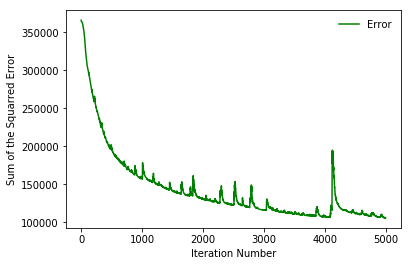

In [20]:
# Plot losss
plt.figure(1)
plt.plot(losslist, color="green", label="Error");
plt.xlabel("Iteration Number")
plt.ylabel("Sum of the Squarred Error")
plt.legend(loc='upper right', frameon=False)

plt.show()

In [21]:
# predict_temp=(test_predict*test_denom[pred_label]+test_min[pred_label])
# predict=np.empty((test_predict.shape[0]+seq_length-1 ,seq_length))

predict_temp=(test_predict)
predict=np.empty((test_predict.shape[0]+seq_length-1 ,seq_length))

predict[:] = np.NAN
for i in range(0,seq_length):
    predict[i:test_predict.shape[0]+i,i]=predict_temp[:,i]
# predict= DataFrame(predict.round())
predict= DataFrame(predict)

In [22]:
Total_size=df.as_matrix().shape[0]
Predict_size=predict.shape[0]

predict_mean=predict.mean(axis =1)
Predict_close_concat=np.concatenate((np.zeros((Total_size-Predict_size,1))[:,-1],
                                     predict_mean), axis=0)

In [23]:
# df["Predict Close"]=Predict_close_concat.round()
df["Predict Close"]=Predict_close_concat

In [24]:
predict_temp=(train_predict)
predict=np.empty((train_predict.shape[0]+seq_length-1 ,seq_length))

predict[:] = np.NAN
for i in range(0,seq_length):
    predict[i:train_predict.shape[0]+i,i]=predict_temp[:,i]
# predict= DataFrame(predict.round())
predict= DataFrame(predict)

In [25]:
Total_size=df.as_matrix().shape[0]
Predict_size=predict.shape[0]

predict_mean=predict.mean(axis =1)
Predict_close_concat=np.concatenate((np.zeros((Total_size-Predict_size,1))[:,-1],
                                     predict_mean), axis=0)

In [26]:
df["Predict Close"]=Predict_close_concat

In [27]:
df.tail(1000)

,Open_rate,High_rate,Low_rate,Close_rate,Volume_rate,Weighted_Price_rate,Predict Close
Date,,,,,,,
2015-02-05,-0.44,-0.87,-4.36,-4.49,-13.35,-2.38,11.105773
2015-02-06,-4.61,-1.37,0.08,3.03,-15.64,-0.08,11.456807
2015-02-07,3.22,2.34,5.31,2.21,-11.76,3.45,9.396529
2015-02-08,2.39,0.76,-2.02,-1.94,42.54,-1.01,4.330993
2015-02-09,-2.12,-2.96,-1.05,-1.33,41.37,-2.34,7.282737
2015-02-10,-1.34,-1.77,0.00,-0.22,-64.66,-0.43,7.320817
2015-02-11,-0.22,0.64,1.39,-0.39,55.12,1.18,4.901559
2015-02-12,-0.39,-0.15,0.01,1.57,-34.77,-0.03,4.435454
2015-02-13,1.57,8.63,1.54,6.28,207.45,5.90,4.909800


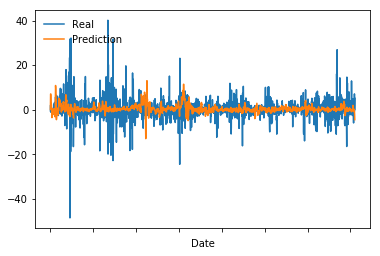

In [28]:
plt.figure(3)
df.iloc[Total_size-Predict_size:,3].plot(label="Real")
df.iloc[Total_size-Predict_size:,6].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()

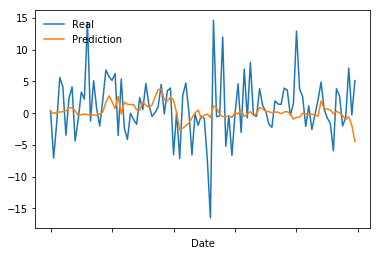

In [29]:
plt.figure(3)
df.iloc[-100:,3].plot(label="Real")
df.iloc[-100:,6].plot(label="Prediction")
plt.legend(loc='upper left', frameon=False)
plt.show()

In [30]:
acc_df = df[train_size:]
acc_np = np.array(acc_df)

In [31]:
count_TP = 0 
count_FP = 0
count_TN = 0
count_FN = 0
for i in acc_np:
    real, prediction = i[3], i[6]
    if real > 0 and prediction > 0:
        count_TP = count_TP+1
    elif real > 0 and prediction < 0:
        count_FN = count_FN+1
    elif real < 0 and prediction > 0:
        count_FP = count_FP+1
    else:
        count_TN = count_TN+1

print("Accuracy: ", (count_TP+count_TN) / (count_TP+count_FP+count_TN+count_FN))
print("Precision: ", (count_TP) / (count_TP+count_FP))
print("Recall: ", (count_TP) / (count_TP+count_FN))

Accuracy:  0.5777777777777777
Precision:  0.6293706293706294
Recall:  0.6818181818181818


In [32]:
acc_df = df[:train_size]
acc_np = np.array(acc_df)

count_TP = 0 
count_FP = 0
count_TN = 0
count_FN = 0
for i in acc_np:
    real, prediction = i[3], i[6]
    if real > 0 and prediction > 0:
        count_TP = count_TP+1
    elif real > 0 and prediction < 0:
        count_FN = count_FN+1
    elif real < 0 and prediction > 0:
        count_FP = count_FP+1
    else:
        count_TN = count_TN+1
    
print("Accuracy: ", (count_TP+count_TN) / (count_TP+count_FP+count_TN+count_FN))
print("Precision: ", (count_TP) / (count_TP+count_FP))
print("Recall: ", (count_TP) / (count_TP+count_FN))

Accuracy:  0.6322033898305085
Precision:  0.538659793814433
Recall:  0.5879043600562588
